In [1]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
from anomalyDetection import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=1,
            latent_dims=10,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

In [2]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

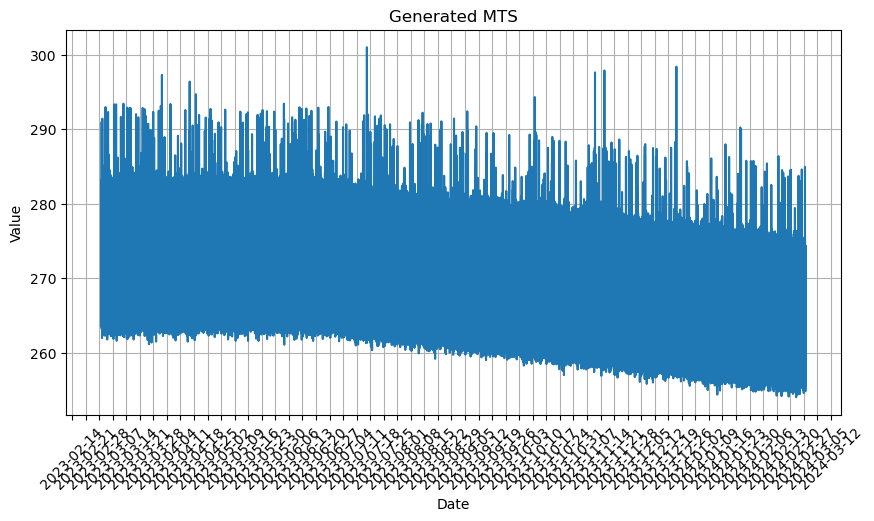

In [3]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=1,
                                                                            return_gen=True,
                                                                            anomalies=True)

In [4]:
seas = {"occurances":1,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":0.8
        }
trend = {"occurances":1,
        "max_slope":0.002,
        "type":"linear",
        "start":0.8
        }

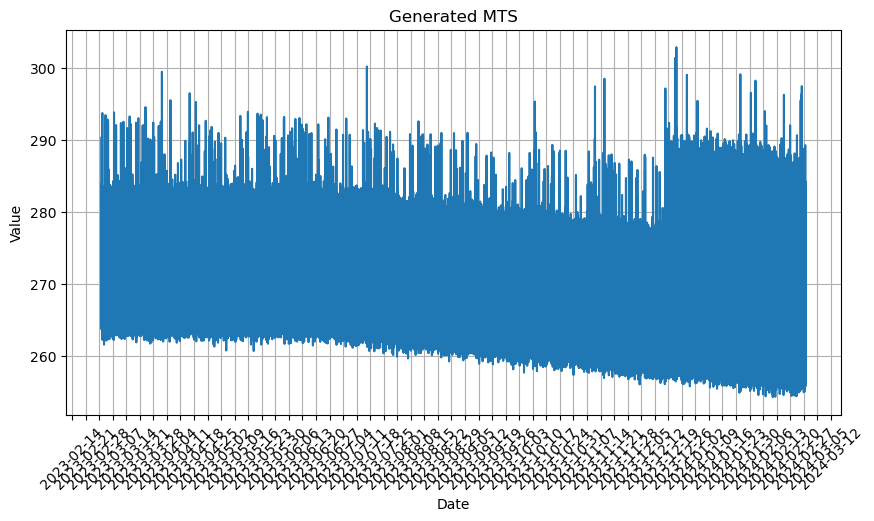

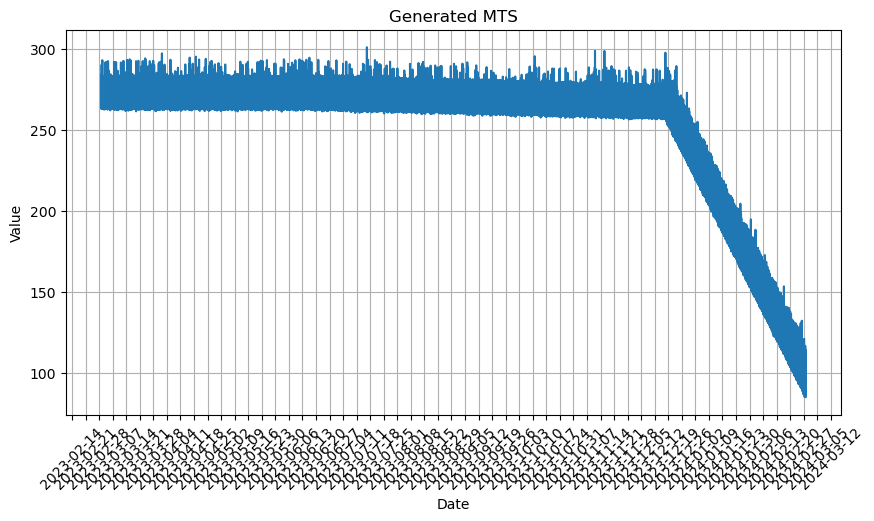

In [5]:
train_data_long_seas, val_data_long_seas, test_data_long_seas, X_long_seas = add_anomaly_long(X_long, args,
                                                                                              "Seasonality", 
                                                                                              seas, 
                                                                                              return_gen=True)
train_data_long_trend, val_data_long_trend, test_data_long_trend, X_long_trend = add_anomaly_long(X_long, args,
                                                                                              "Trend", 
                                                                                              trend, 
                                                                                              return_gen=True)

In [6]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

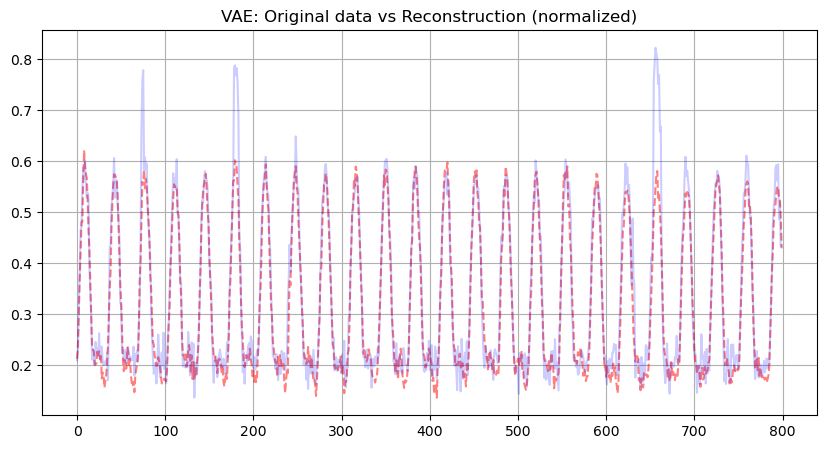

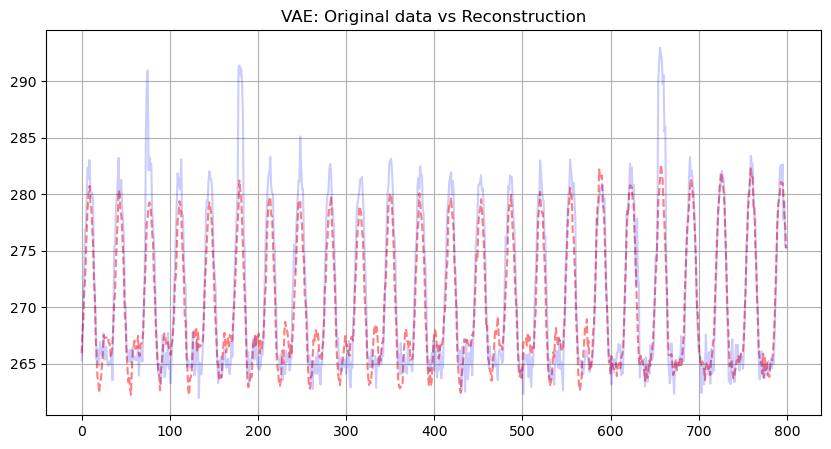

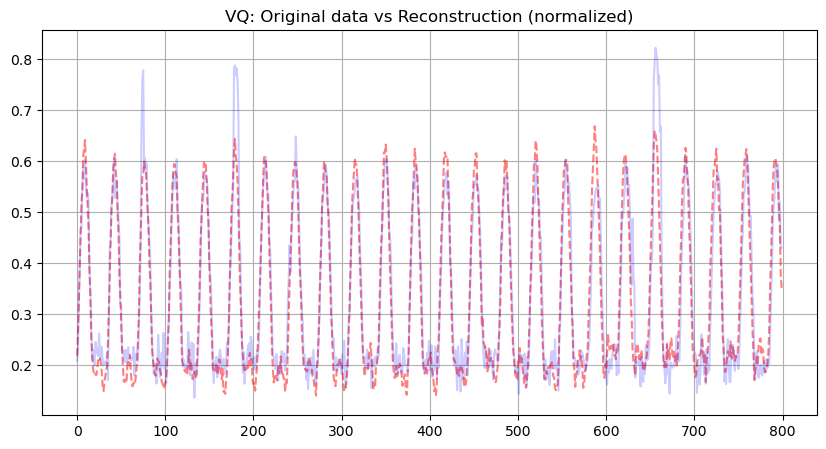

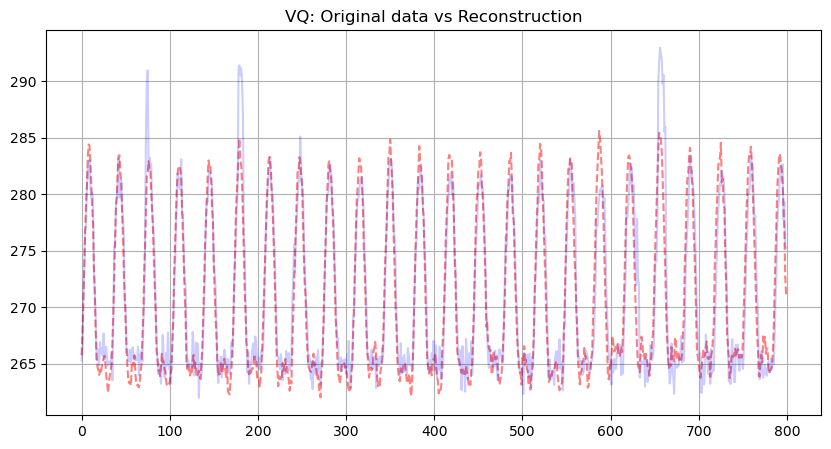

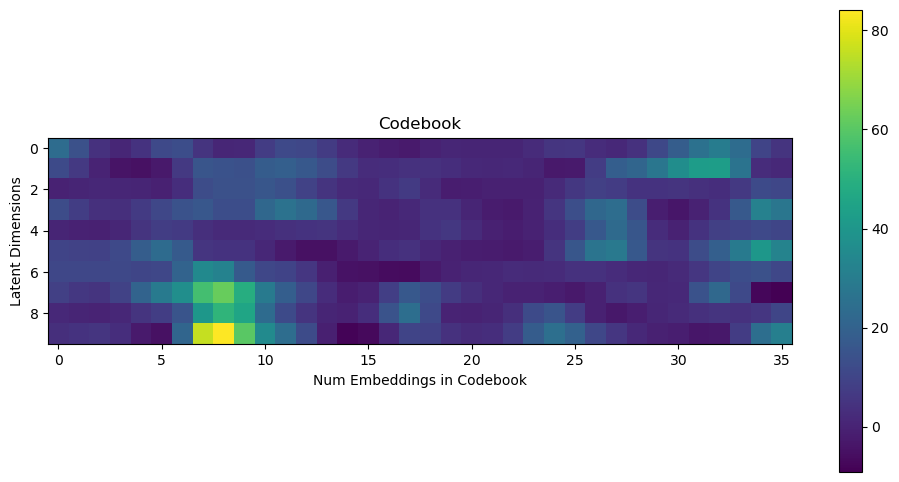

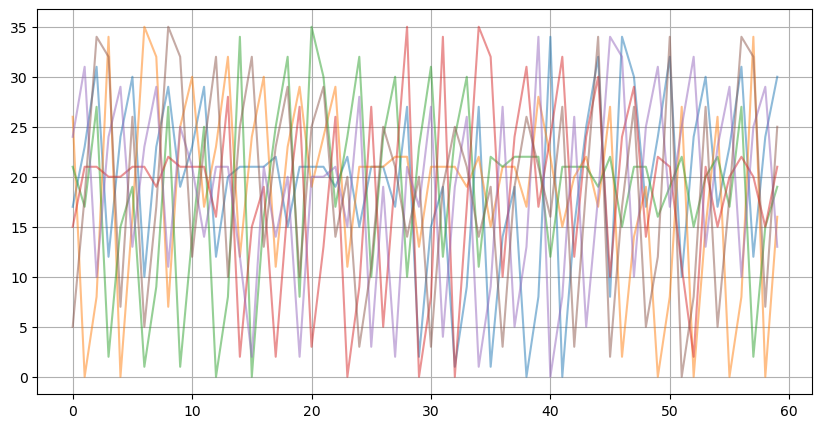

====> VAE: Sample 1901 Average loss: 0.0204
====> VQ: Sample 1901 Average loss: 0.0316
Train Epoch: 1902 [0/1 (0%)]	Loss: 3.047499	 True Loss: 441.887390
Train Epoch: 1902 [0/1 (0%)]	Loss: 4.550193	 True Loss: 659.777954
====> VAE: Sample 1902 Average loss: 0.0210
====> VQ: Sample 1902 Average loss: 0.0314
Train Epoch: 1903 [0/1 (0%)]	Loss: 3.013016	 True Loss: 436.887299
Train Epoch: 1903 [0/1 (0%)]	Loss: 4.479038	 True Loss: 649.460571
====> VAE: Sample 1903 Average loss: 0.0208
====> VQ: Sample 1903 Average loss: 0.0309
Train Epoch: 1904 [0/1 (0%)]	Loss: 3.065476	 True Loss: 444.494080
Train Epoch: 1904 [0/1 (0%)]	Loss: 4.517906	 True Loss: 655.096436
====> VAE: Sample 1904 Average loss: 0.0211
====> VQ: Sample 1904 Average loss: 0.0312
Train Epoch: 1905 [0/1 (0%)]	Loss: 2.934224	 True Loss: 425.462524
Train Epoch: 1905 [0/1 (0%)]	Loss: 4.557470	 True Loss: 660.833191
====> VAE: Sample 1905 Average loss: 0.0202
====> VQ: Sample 1905 Average loss: 0.0314
Train Epoch: 1906 [0/1 (0%)]	

Train Epoch: 1939 [0/1 (0%)]	Loss: 2.863331	 True Loss: 415.183044
Train Epoch: 1939 [0/1 (0%)]	Loss: 4.455506	 True Loss: 646.048340
====> VAE: Sample 1939 Average loss: 0.0197
====> VQ: Sample 1939 Average loss: 0.0307
Train Epoch: 1940 [0/1 (0%)]	Loss: 2.915173	 True Loss: 422.700073
Train Epoch: 1940 [0/1 (0%)]	Loss: 4.499574	 True Loss: 652.438293
====> VAE: Sample 1940 Average loss: 0.0201
====> VQ: Sample 1940 Average loss: 0.0310
Train Epoch: 1941 [0/1 (0%)]	Loss: 2.924909	 True Loss: 424.111816
Train Epoch: 1941 [0/1 (0%)]	Loss: 4.573882	 True Loss: 663.212952
====> VAE: Sample 1941 Average loss: 0.0202
====> VQ: Sample 1941 Average loss: 0.0315
Train Epoch: 1942 [0/1 (0%)]	Loss: 2.945177	 True Loss: 427.050659
Train Epoch: 1942 [0/1 (0%)]	Loss: 4.547430	 True Loss: 659.377380
====> VAE: Sample 1942 Average loss: 0.0203
====> VQ: Sample 1942 Average loss: 0.0314
Train Epoch: 1943 [0/1 (0%)]	Loss: 2.898657	 True Loss: 420.305328
Train Epoch: 1943 [0/1 (0%)]	Loss: 4.493970	 True

Train Epoch: 1978 [0/1 (0%)]	Loss: 2.821898	 True Loss: 409.175171
Train Epoch: 1978 [0/1 (0%)]	Loss: 4.466563	 True Loss: 647.651611
====> VAE: Sample 1978 Average loss: 0.0195
====> VQ: Sample 1978 Average loss: 0.0308
Train Epoch: 1979 [0/1 (0%)]	Loss: 2.844286	 True Loss: 412.421539
Train Epoch: 1979 [0/1 (0%)]	Loss: 4.460821	 True Loss: 646.819092
====> VAE: Sample 1979 Average loss: 0.0196
====> VQ: Sample 1979 Average loss: 0.0308
Train Epoch: 1980 [0/1 (0%)]	Loss: 2.942973	 True Loss: 426.731110
Train Epoch: 1980 [0/1 (0%)]	Loss: 4.565566	 True Loss: 662.007019
====> VAE: Sample 1980 Average loss: 0.0203
====> VQ: Sample 1980 Average loss: 0.0315
Train Epoch: 1981 [0/1 (0%)]	Loss: 2.961999	 True Loss: 429.489807
Train Epoch: 1981 [0/1 (0%)]	Loss: 4.487148	 True Loss: 650.636414
====> VAE: Sample 1981 Average loss: 0.0204
====> VQ: Sample 1981 Average loss: 0.0309
Train Epoch: 1982 [0/1 (0%)]	Loss: 2.876822	 True Loss: 417.139160
Train Epoch: 1982 [0/1 (0%)]	Loss: 4.564426	 True

In [7]:
args.min_max= True
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []
args.robust= False

for epoch in range(1, 2000):
    loss_vae = train(vae, train_data_long, args, opt_vae, epoch)
    loss_vq = train(vq, train_data_long, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results_long(vae, train_data_long, args)
        show_results_long(vq, train_data_long, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
                
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data_long.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data_long.dataset)))

In [40]:
from anomalyDetection import *
vae_labels = get_anomalies_labels(X_long, vq, train_data_long, args, norm=False, group_size=1)
vae_predictions = get_anomalies_prediction(X_long, vq, train_data_long, args, norm=False, group_size=1, threshold=40)

for i, (label, pred) in enumerate(zip(vae_labels, vae_predictions)):
#     print(label.shape)
#     print(len(np.where(label==False)[0]))
    accuracy = accuracy_score(label, pred)
#     print(accuracy)
    recall = recall_score(label.T, pred.T, average='macro')
#     print(recall)
    f1 = f1_score(label.T, pred.T, average='macro')
#     print(f1)

    fpr, tpr, thresholds = roc_curve(label, y_scores[i], drop_intermediate=False)
#     print(tpr.shape)
    roc_auc = auc(fpr, tpr)   # roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [83520, 10368]

In [41]:
rec_loss = get_rec_loss(vae, test_data_long_trend, args)

In [42]:
vae_labels = get_anomalies_labels(X_long, vae, test_data_long, args)
vae_predictions = get_anomalies_prediction(X_long, vae, test_data_long, args)
vae_predictions.shape

(1, 3456)

In [43]:
y_scores = get_y_scores(rec_loss, args)
y_scores.shape

(1, 10368)

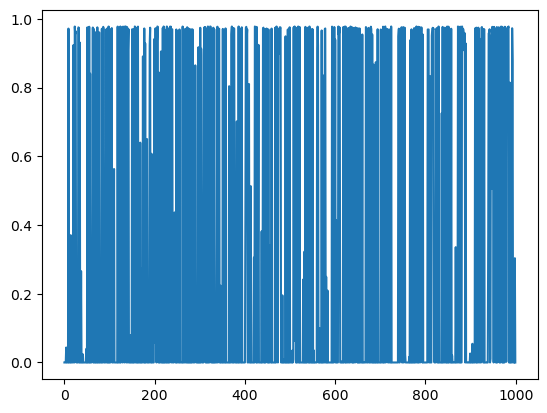

In [57]:
plt.plot(y_scores[0, :1000].T)

In [46]:
def get_anomalies_from_y_scores(y_scores, args):
    #Create a mask for the anomalies
    anomalies_mask = np.full(y_scores.shape, False)

    for channel in range(args.n_channels):
        anomalies = np.where(y_scores[i] > 0.8)[0]
        anomalies_mask[i, anomalies] = True

#     # Reduce the size of mask (grouped values)
#     anomalies_reshaped_mask = anomalies_mask.reshape(-1, 1)
#     predictions = np.any(anomalies_reshaped_mask, axis=1)
    return anomalies

anomalies = get_anomalies_from_y_scores(y_scores, args)

In [55]:
def get_anomalies_sector(anomalies, max_length=500):
    some_anomalies = np.where(anomalies<max_length)[0]
    sector_anomalies = anomalies[some_anomalies]
    return sector_anomalies
sector_anomalies = get_anomalies_sector(anomalies, 5000)

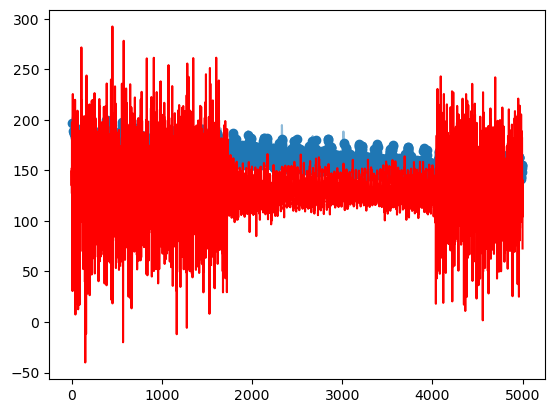

In [56]:
Origin, REC, _ = rebuild_TS_non_overlapping(vae, test_data_long_trend, args, keep_norm=False)

plt.plot(Origin.cpu()[:5000], alpha=0.5)
plt.plot(REC.cpu()[:5000], "-r")
plt.scatter(sector_anomalies, Origin[sector_anomalies].cpu())